In [3]:
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path_to_write='/media/sergio/Meninges/SpatialData_formatted/'

In [5]:
adata=sc.read(path_to_write+'adata_for_velocity_pancreas_processed.h5ad')

# Subset_clusters_involved_in_trajectory

In [6]:
clusters=['22','16']
adata=adata[adata.obs['leiden'].isin(clusters)]

In [17]:
adata

AnnData object with n_obs × n_vars = 1521 × 21632
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'X', 'version', 'Run_name', 'Run_Tissue_name', 'tissue', 'Panel', 'assay_type', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'Area.um2', 'cell', 'n_counts', 'n_genes', 'leiden', 'leiden_velocity', 'velocity_self_transition'
    var: 'n_cells', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'leiden_velocity_colors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap', 'spatia

/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


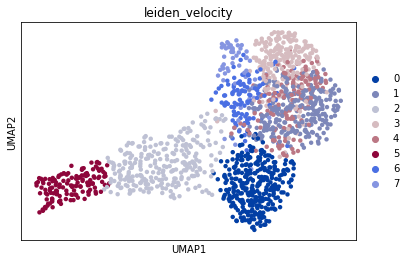

In [18]:
sc.pp.neighbors(adata,n_neighbors = 8 , n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata,key_added='leiden_velocity',resolution=1.0)
sc.pl.umap(adata,color='leiden_velocity')

In [10]:
adata.write(path_to_write+'adata_for_velocity_pancreas_processed_input.h5ad')

# Run RNA velocity and explore

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/1521 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


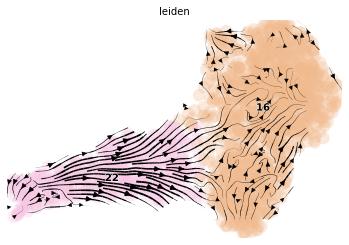

In [11]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden')

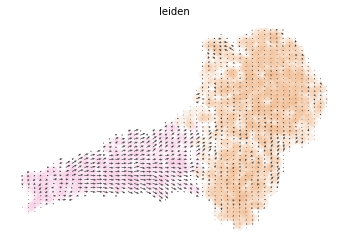

In [12]:
scv.pl.velocity_embedding_grid(adata, basis='umap', color='leiden')

In [14]:
adata.write(path_to_write+'adata_for_velocity_pancreas_processed_trajectory_output.h5ad')

In [7]:
adata=sc.read(path_to_write+'adata_for_velocity_pancreas_processed_trajectory_output.h5ad')

In [19]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/32 cores)


  0%|          | 0/238 [00:00<?, ?gene/s]

    finished (0:00:50) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [20]:
adata.write(path_to_write+'adata_for_velocity_pancreas_processed_trajectory_with_dynamics.h5ad')

# Generate pseudotime

In [136]:
adata2=adata.copy()
adata2.obs=adata2.obs.reset_index()
asub=adata2[adata2.obs['leiden']=='7']
asub.obs.index=asub.obs.index.astype(str)
for a in asub.obs['cell_id'].unique():
    asub2=asub[asub.obs['cell_id']==a]
    plt.figure(figsize=(4,4))
    plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],c='lightgrey',s=1)
    plt.scatter(asub2.obsm['X_umap'][:,0],asub2.obsm['X_umap'][:,1],c='blue',s=1)
    plt.title(asub2.obs.index[0])
    plt.show()

computing terminal states
    identified 3 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


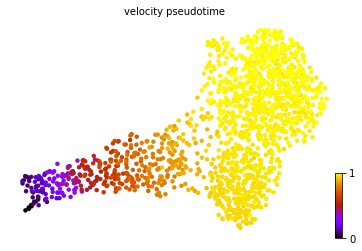

In [21]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

Renamed 'spatial' to convention 'X_spatial' (adata.obsm).


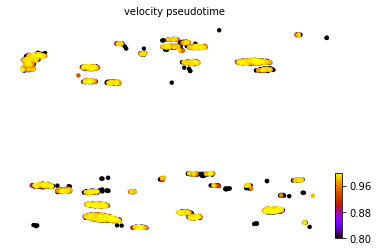

In [22]:
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot',basis='spatial',vmin=0.8)

# Explore gene-specific dynamics

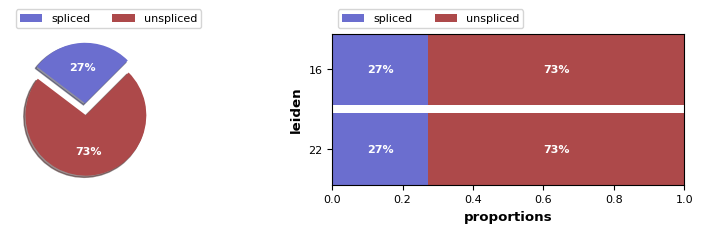

In [26]:
scv.pl.proportions(adata,groupby='leiden')

We define how many genes are considered velocity genes

In [27]:
print('A total of ',np.sum(adata.var['velocity_genes'] == True),' genes are velocity genes')

A total of  238  genes are velocity genes


In [28]:
adata.var.columns

Index(['n_cells', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2',
       'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_',
       'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0',
       'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s',
       'fit_variance', 'fit_alignment_scaling'],
      dtype='object')

We first identify which genes have expression in the trajectory

In [30]:
#adata.var.index=adata.var['gene_name']
likelihood_genes = adata.var['fit_likelihood'].sort_values(ascending=False)
likelihood_genes=pd.DataFrame(likelihood_genes[likelihood_genes>0])
sum_expression=pd.DataFrame(np.sum(adata.to_df(),axis=0),columns=['sum_expression'])

In [31]:
likelihood_n_expression=pd.concat([likelihood_genes,sum_expression],axis=1)

Text(0, 0.5, 'Sum_expression')

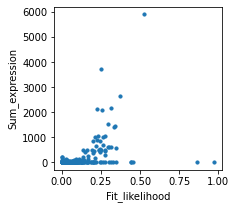

In [32]:
plt.figure(figsize=(3,3))
plt.scatter(likelihood_n_expression['fit_likelihood'],likelihood_n_expression['sum_expression'],s=10)
plt.xlabel('Fit_likelihood')
plt.ylabel('Sum_expression')

### We plot genes with highest likelihood

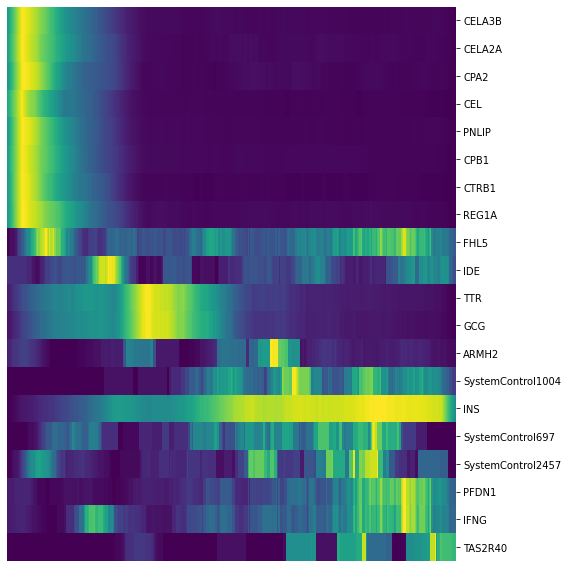

In [34]:
scv.pl.heatmap(adata, var_names=likelihood_genes.index[0:20], sortby='velocity_pseudotime',  n_convolve=100,figsize=(8,8))

### We plot genes with lowest likelihood

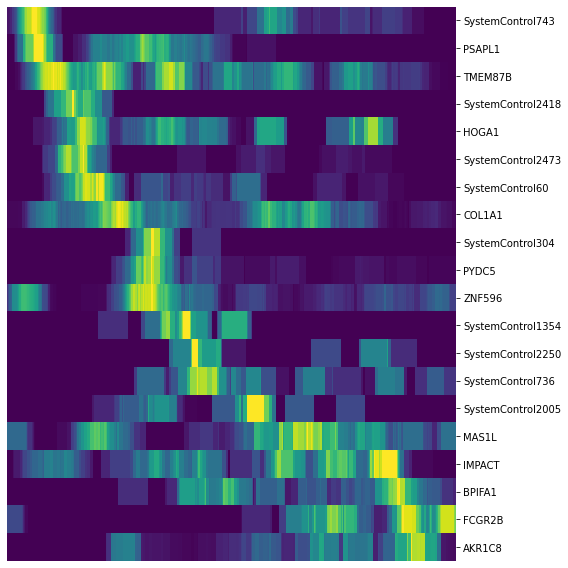

In [35]:
scv.pl.heatmap(adata, var_names=likelihood_genes.index[-20:], sortby='velocity_pseudotime',  n_convolve=100,figsize=(8,8))

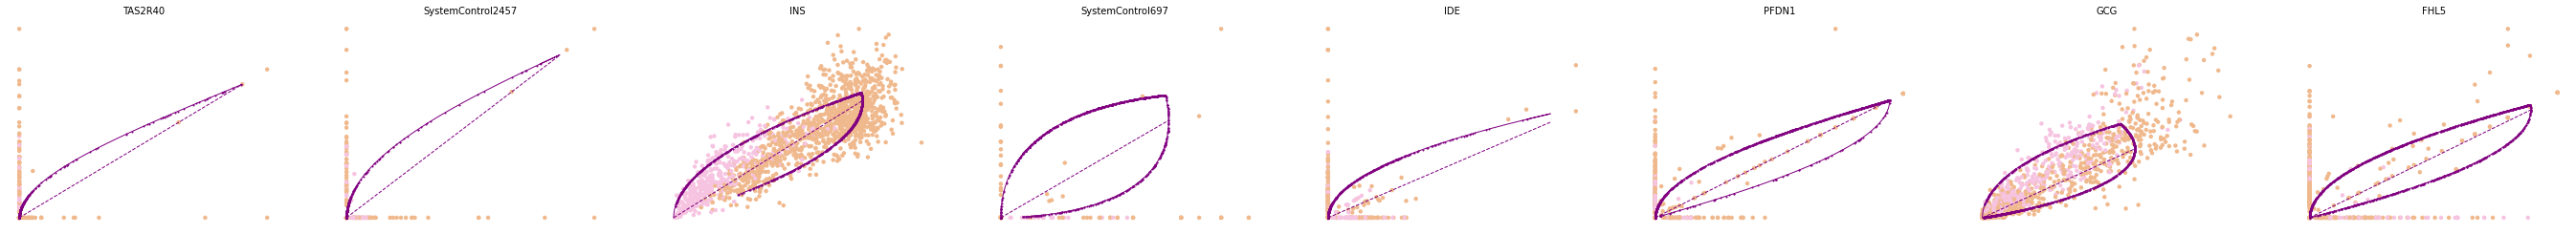

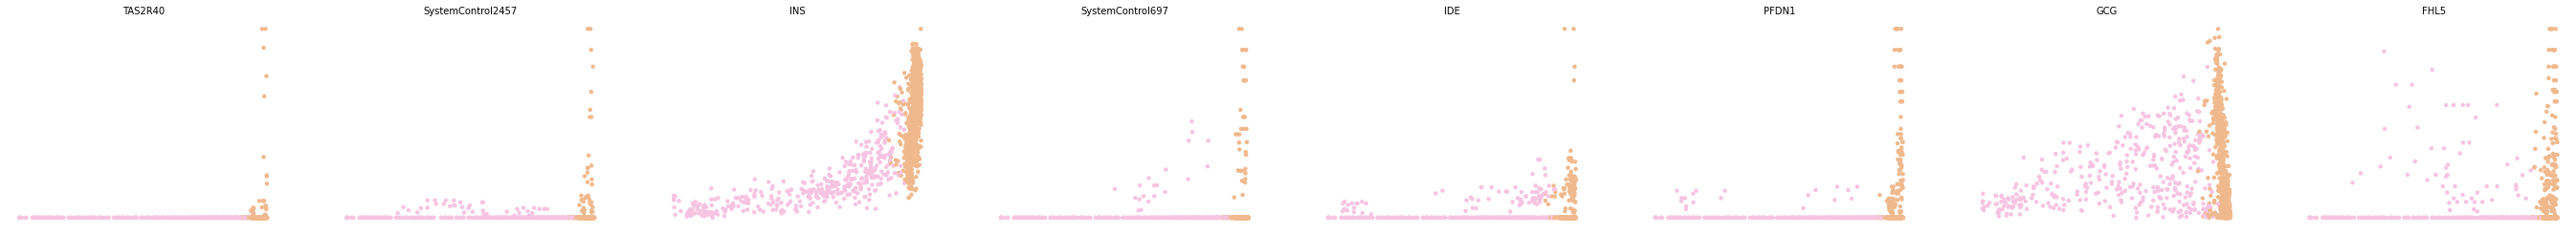

In [36]:
var_names = likelihood_genes.index[0:8]
scv.pl.scatter(adata, var_names, frameon=False,color='leiden')
scv.pl.scatter(adata, x='velocity_pseudotime', y=var_names, frameon=False,color='leiden')


# Plot spliced and unspliced counts against pseudotime

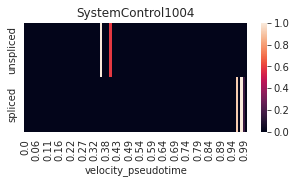

<Figure size 288x144 with 0 Axes>

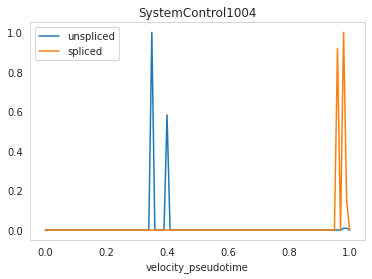

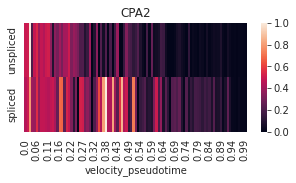

<Figure size 288x144 with 0 Axes>

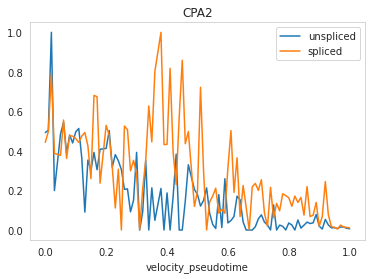

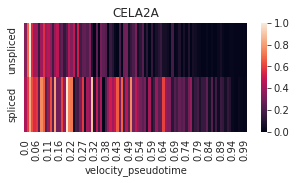

<Figure size 288x144 with 0 Axes>

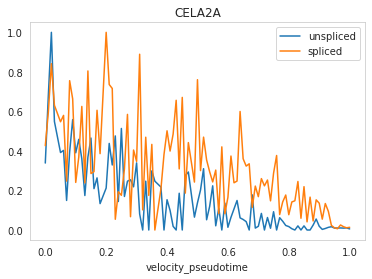

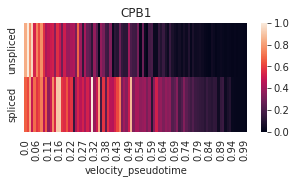

<Figure size 288x144 with 0 Axes>

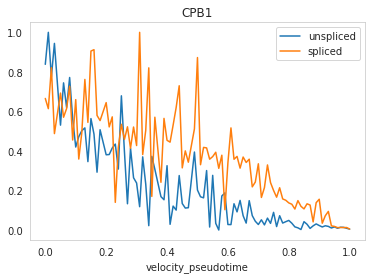

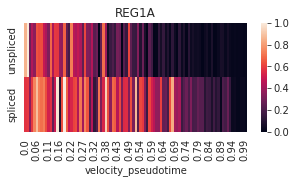

<Figure size 288x144 with 0 Axes>

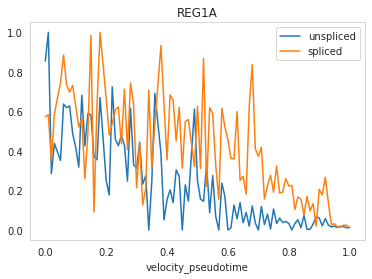

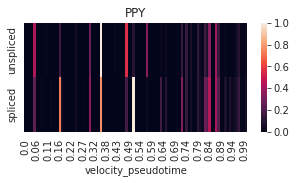

<Figure size 288x144 with 0 Axes>

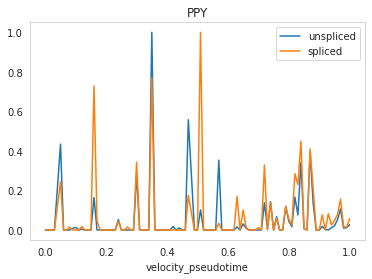

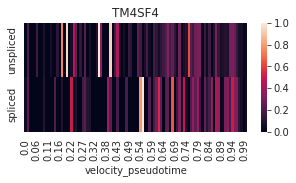

<Figure size 288x144 with 0 Axes>

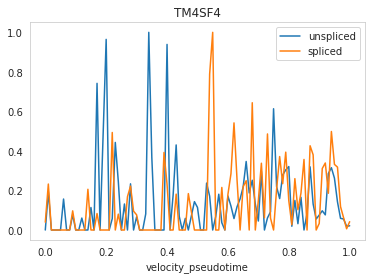

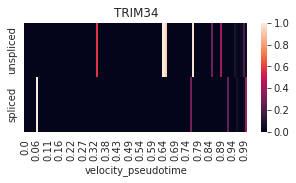

<Figure size 288x144 with 0 Axes>

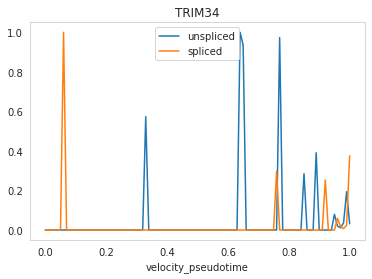

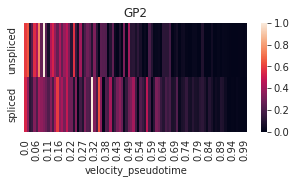

<Figure size 288x144 with 0 Axes>

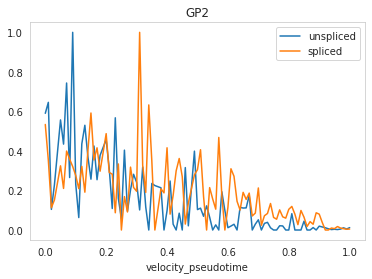

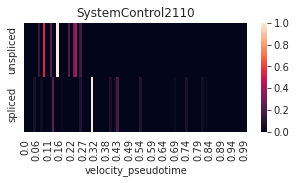

<Figure size 288x144 with 0 Axes>

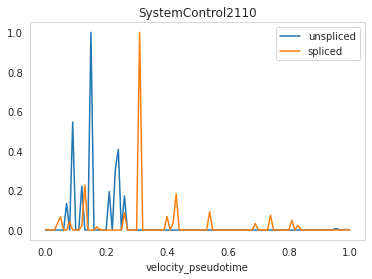

In [37]:

var_names = likelihood_genes.index[15:25]

spliced=pd.DataFrame(adata.layers['spliced'],columns=adata.var.index,index=adata.obs.index)
unspliced=pd.DataFrame(adata.layers['unspliced'],columns=adata.var.index,index=adata.obs.index)
#spliced=np.log(spliced+0.1)
#unspliced=np.log(unspliced+0.1)
spliced['velocity_pseudotime']=np.round(adata.obs['velocity_pseudotime'],2)
unspliced['velocity_pseudotime']=np.round(adata.obs['velocity_pseudotime'],2)
spliced=spliced.groupby('velocity_pseudotime').mean()
unspliced=unspliced.groupby('velocity_pseudotime').mean()


sns.set_style("whitegrid", {'axes.grid' : False})
for g in var_names:
    plt.figure(figsize=(5,2))
    comb=pd.concat([unspliced.loc[:,[g]],spliced.loc[:,[g]]],axis=1)
    comb.columns=['unspliced','spliced']
    comb=comb.transpose()
    #comb=np.log(comb+1)
    comb=comb.div(np.max(comb,axis=1),axis=0)
    sns.heatmap(comb)
    plt.title(g)
    plt.show()
    plt.figure(figsize=(4,2))
    comb.transpose().plot()
    plt.title(g)
    plt.show()

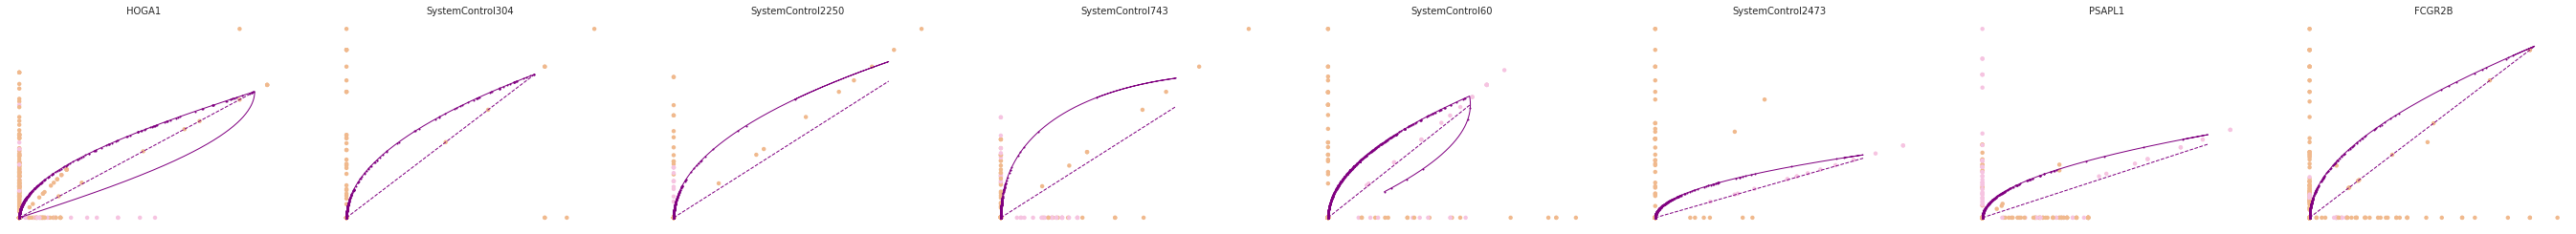

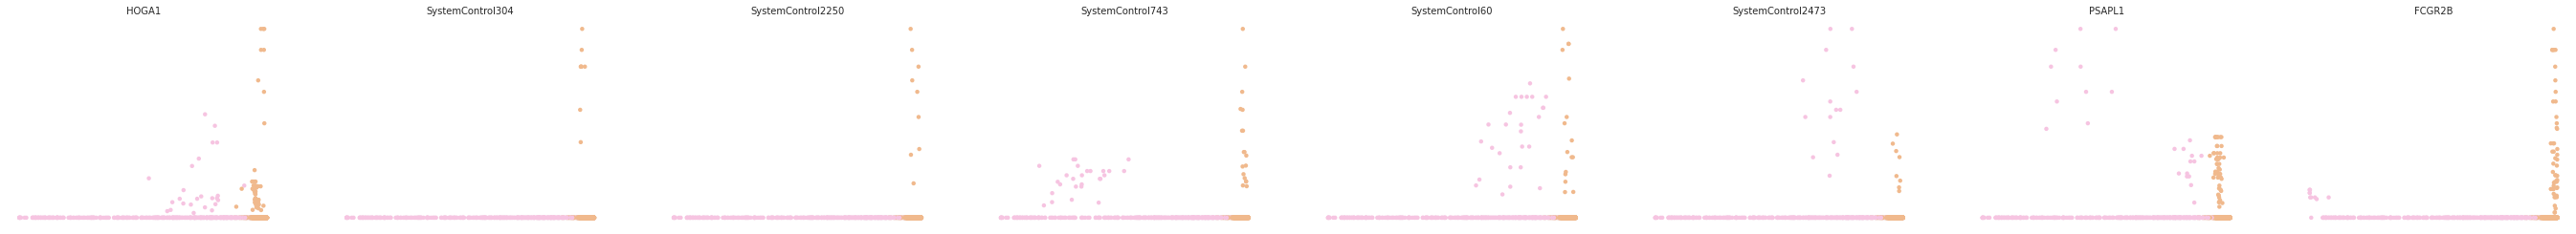

In [38]:
var_names = likelihood_genes.index[-8:]
scv.pl.scatter(adata, var_names, frameon=False,color='leiden')
scv.pl.scatter(adata, x='velocity_pseudotime', y=var_names, frameon=False,color='leiden')


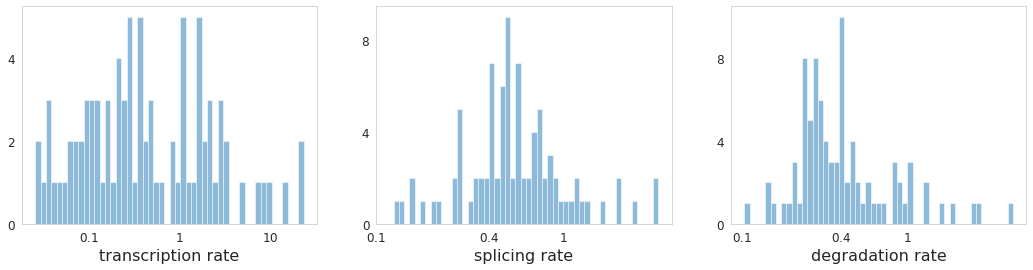

/tmp/ipykernel_1296151/3880792842.py:10: DeprecationWarning: `get_df` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please `AnnData::get_df` or Scanpy's `scanpy.get.obs_df` or `scanpy.get.var_df`.
  scv.get_df(adata, 'fit*', dropna=True).head()


fit_alpha  fit_beta  fit_gamma     fit_t_  fit_scaling  fit_std_u  \
target                                                                      
AASS     0.073092  0.094837   0.260913   5.774561     3.802111   0.178733   
AGA      1.665348  2.724566   1.878707   6.793763     0.302283   0.223207   
AGAP2    0.593376  0.813959   0.865049  15.451730     1.261700   0.325311   
AKR1C8   0.414038  1.379078   0.188771  24.519448     0.063063   0.082609   
AMY1C    0.609322  0.209102   0.295225   7.244219     2.007802   0.771106   

        fit_std_s  fit_likelihood  fit_u0  fit_s0  fit_pval_steady  \
target                                                               
AASS     0.054295        0.007872     0.0     0.0         0.367424   
AGA      0.332281        0.212072     0.0     0.0         0.487439   
AGAP2    0.300808        0.079819     0.0     0.0         0.468179   
AKR1C8   0.726471        0.000030     0.0     0.0         0.485834   
AMY1C    0.517514        0.208780     0.0     0.0         0.486281   

        fit_steady_u  fit_steady_s  fit_variance  fit_alignment_scaling  
target                                                                   
AASS        0.309878      0.111421      0.447368               2.814218  
AGA         0.523079      0.790306      0.116289               0.546388  
AGAP2       0.731910      0.688961      0.267968               1.136025  
AKR1C8      0.172661      1.196637      0.055460               6.482177  
AMY1C       2.562421      1.329011      0.861492               2.751079

In [39]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()


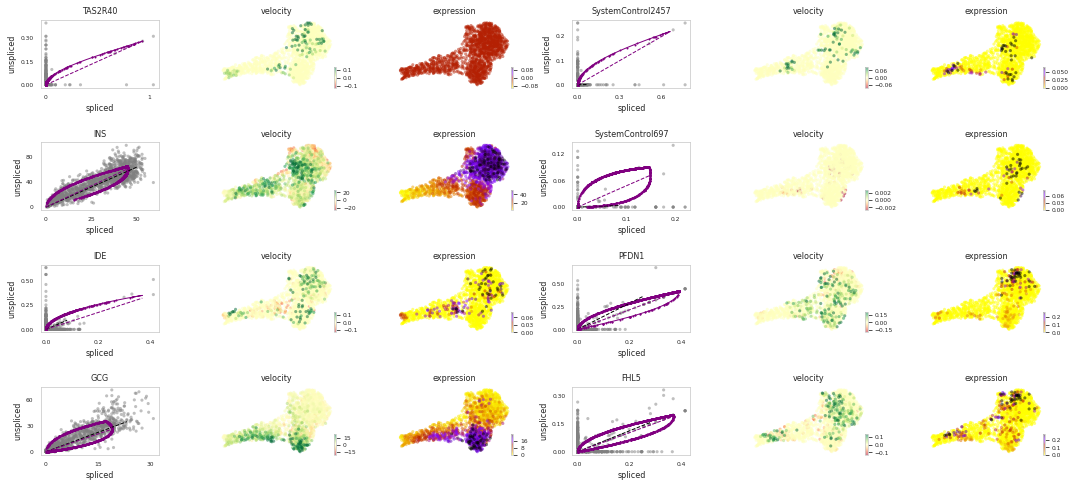

In [40]:
scv.pl.velocity(adata, likelihood_genes.index[:8], ncols=2)

# Runnning dynamical velocity

In [41]:
scv.tl.velocity(adata,mode='dynamical')

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [42]:
adata.write(path_to_write+'adata_for_velocity_pancreas_processed_trajectory_with_dynamical.h5ad')

In [45]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/32 cores)


  0%|          | 0/1521 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


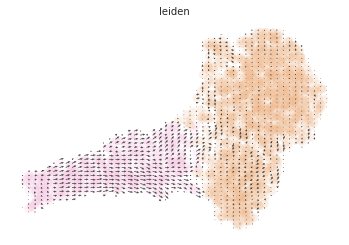

In [46]:
scv.pl.velocity_embedding_grid(adata, basis='umap', color='leiden')

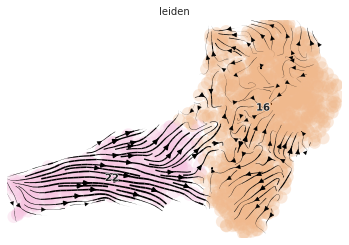

In [47]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden')

# Explore confidence

In [49]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


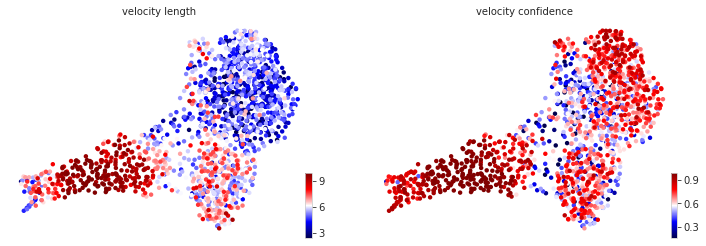

In [50]:
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
scv.pl.scatter(adata, c=keys, perc=[2, 98],cmap='seismic')

## Trajectory with only high likelyhood genes (0.1 is minimum) [dynamical model]

In [412]:
scv.tl.velocity(adata,mode='dynamical',min_likelihood=0.000001)

computing velocities
    finished (0:01:58) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [413]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/32 cores)


  0%|          | 0/296043 [00:00<?, ?cells/s]

    finished (0:03:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)


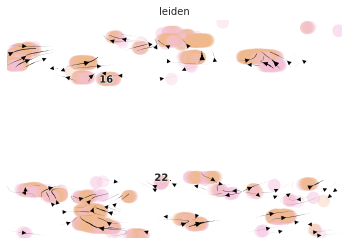

In [51]:
scv.pl.velocity_embedding_stream(adata, basis='spatial', color='leiden')

computing velocity embedding
    finished (0:01:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


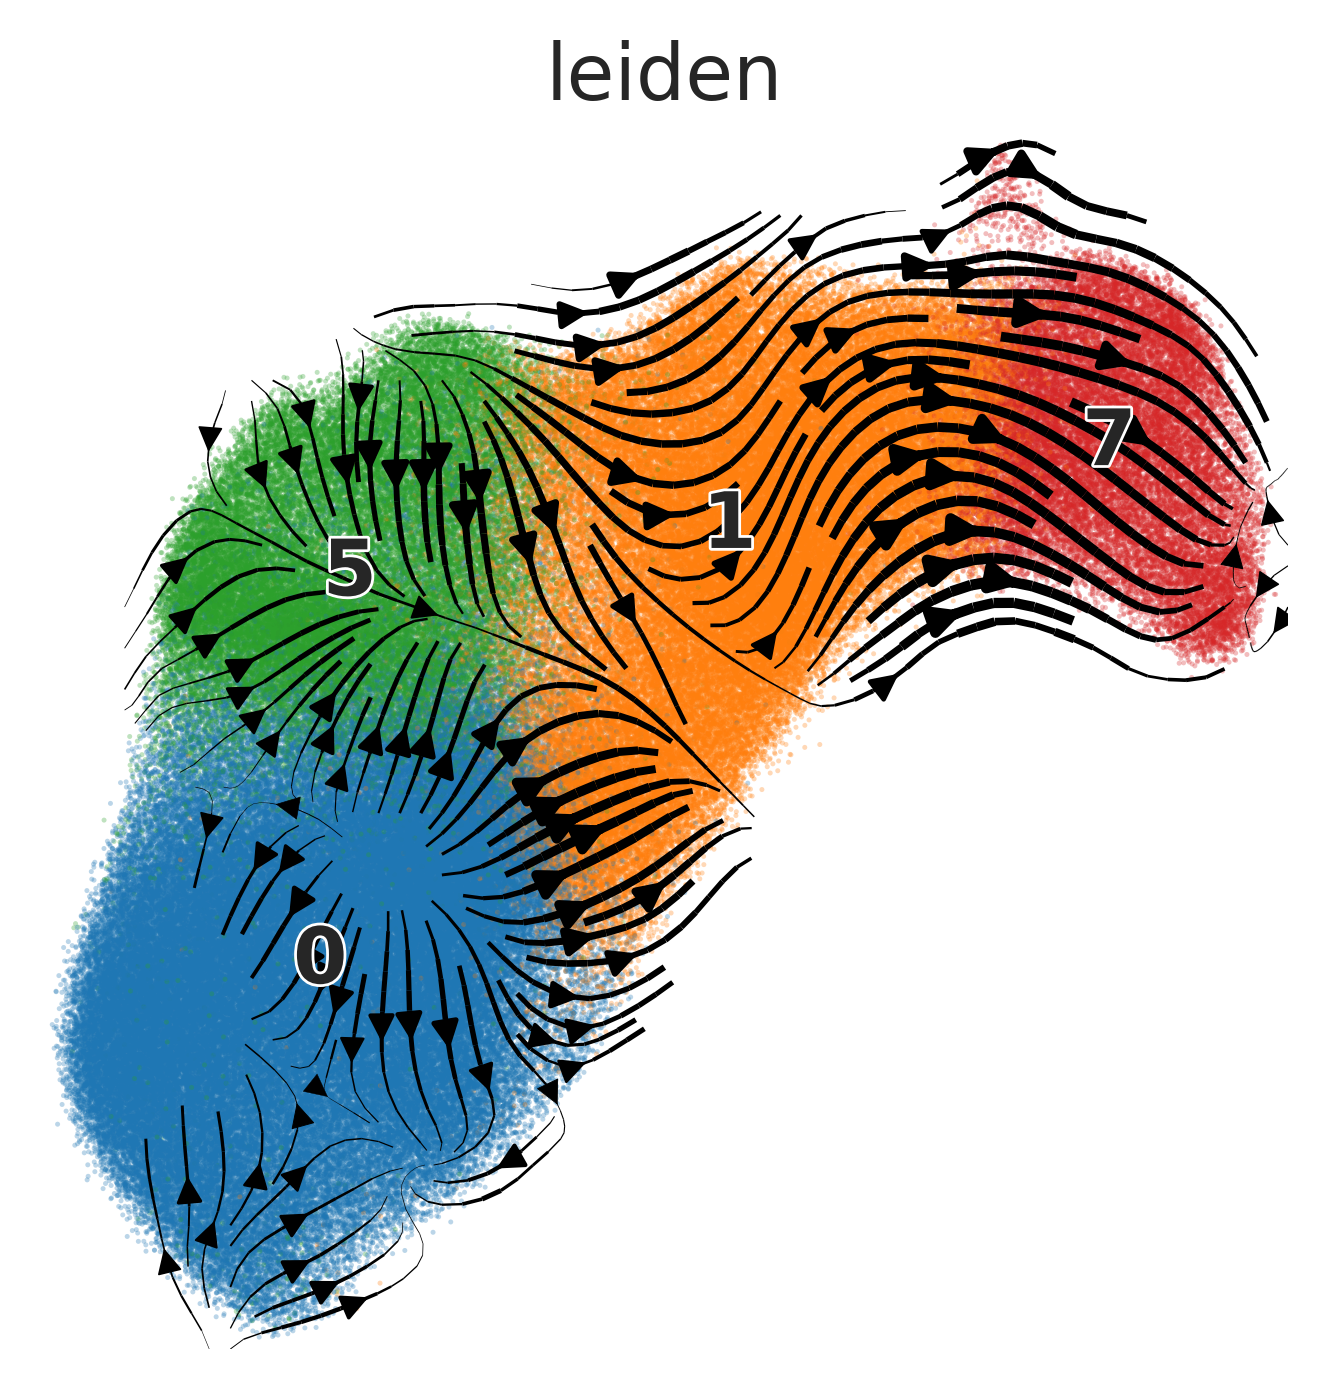

In [414]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden')

computing velocity embedding
    finished (0:01:08) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


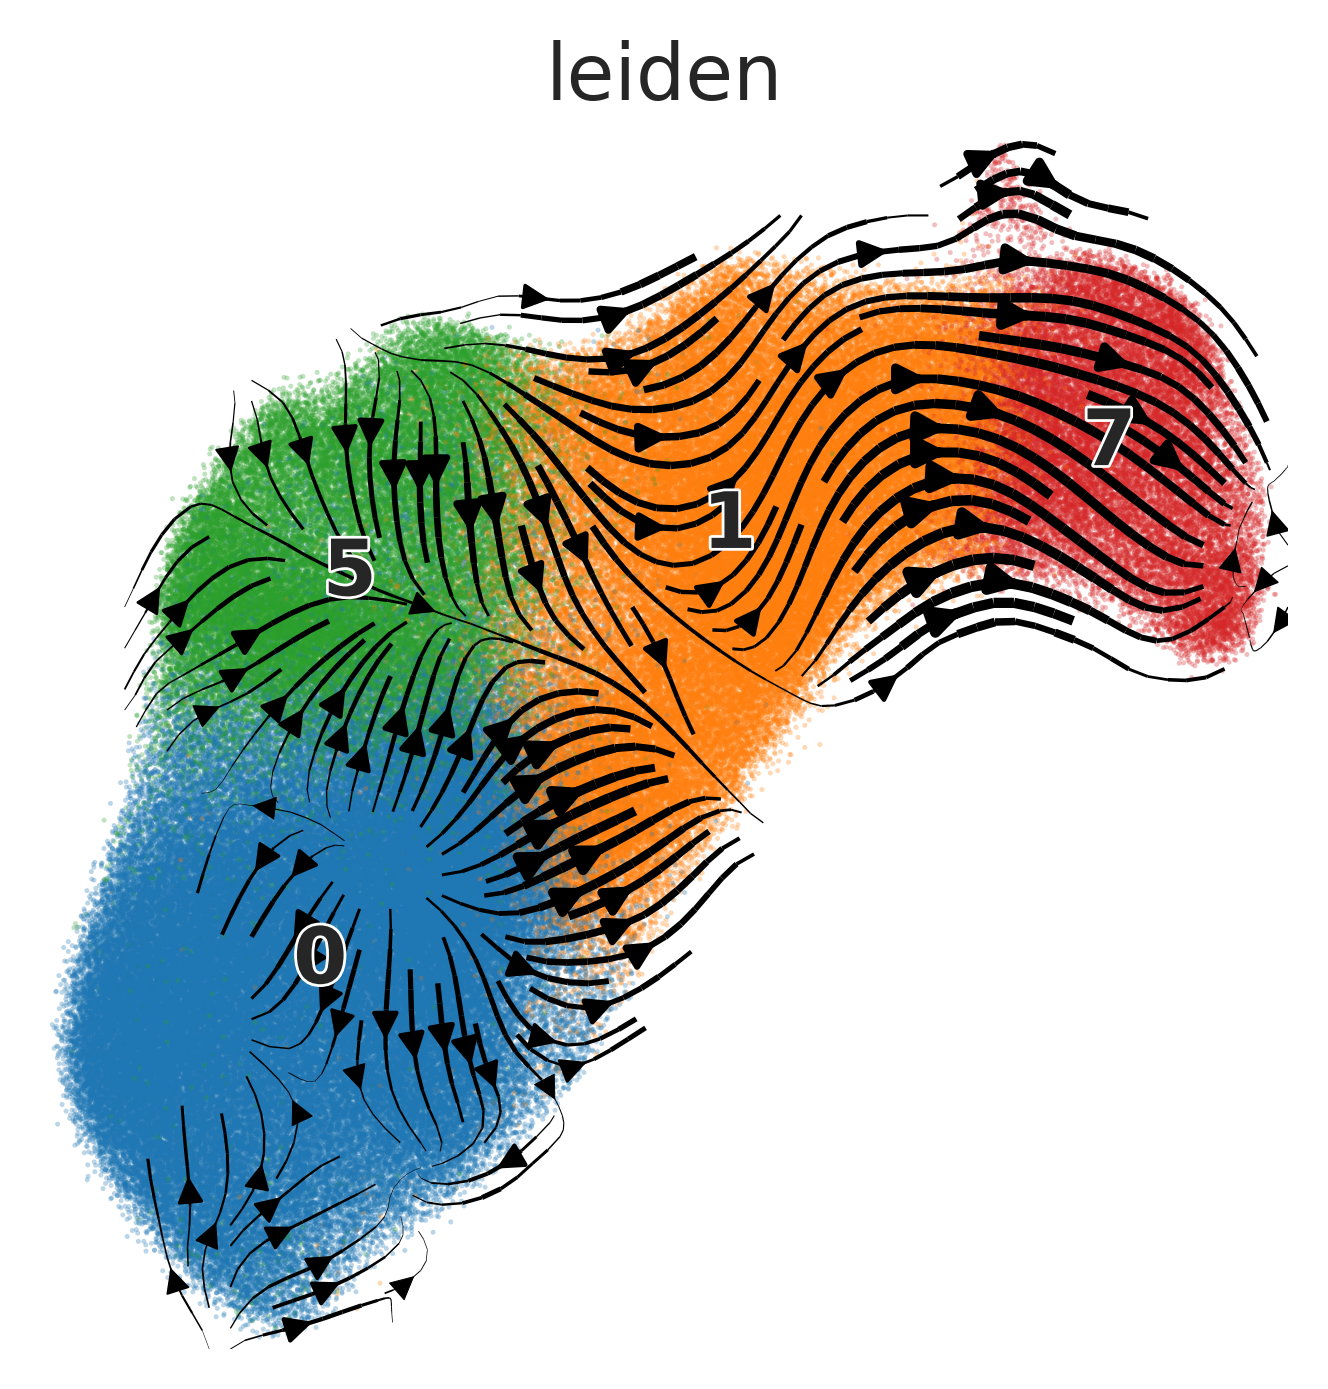

In [408]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden')